# Introduction
This notebook is exploratory and dedicated to comparing the Adaboost algorithm with different base estimators. Adaboost or Adaptive boosting is an ML algroithm that uses simple or week learners. "Boosting is used to reduce bias as well as the variance for supervised learning"(Ashish Kumar). Here we will use five different base learners and compare the differences across four metrics. All of this will be done on the heart disease UCI dataset taken from Kaggle. The link to which is here: https://www.kaggle.com/ronitf/heart-disease-uci. This is about the performance of the algorithm for this classification task and not the underlying data. There will not be a formal analysis if the dataset in this notebook.

# Exploration

## Import libraries and load the data
The first task is to import the libraries we will be using to hold the data and display the results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('heart.csv')
y = data['target']
X = data.drop(['target'], axis=1)
print('Label shape:    {}'.format(y.shape))
print('Features shape: {}'.format(X.shape))
data.head()

Label shape:    (303,)
Features shape: (303, 13)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


As we can see above, the target is whether the individual has or does not have heart disease.<br>
Next, we will look at the data types, counts and unique values within each feature and if there are any missing or null values.

In [3]:
def df_stats(df):
    lines = df.shape[0]
    d_types = df.dtypes
    counts = df.apply(lambda x: x.count())
    unique = df.apply(lambda x: x.unique().shape[0])
    nulls = df.isnull().sum()
    missing_ratio = (df.isnull().sum()/lines)*100
    col_names = ['dtypes', 'counts', 'unique', 'nulls', 'missing_ratio']
    temp = pd.concat([d_types, counts, unique, nulls, missing_ratio], axis=1)
    temp.columns = col_names
    return temp
    
st = df_stats(data)
st

,dtypes,counts,unique,nulls,missing_ratio
age,int64,303,41,0,0.0
sex,int64,303,2,0,0.0
cp,int64,303,4,0,0.0
trestbps,int64,303,49,0,0.0
chol,int64,303,152,0,0.0
fbs,int64,303,2,0,0.0
restecg,int64,303,3,0,0.0
thalach,int64,303,91,0,0.0
exang,int64,303,2,0,0.0
oldpeak,float64,303,40,0,0.0


Above we can clearly see what features are categorical and which are numeric.<br>
Next, we will plot the categorical features and the target.


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
train_df = pd.concat((X_train, y_train), axis=1)

Text(0.5, 1.0, 'Target Variable')

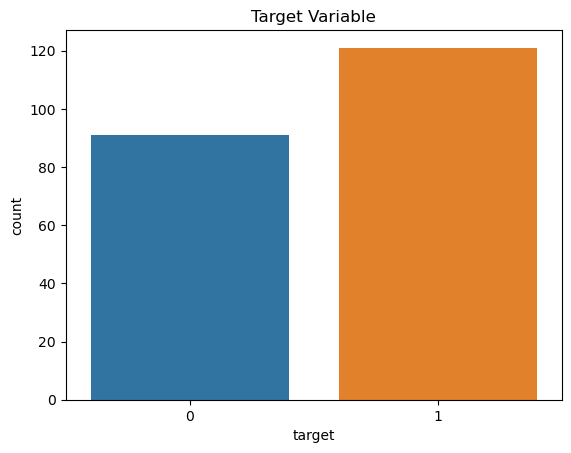

In [5]:
sns.countplot(x='target', data=train_df)
plt.title('Target Variable')

The target is close to evenly split.

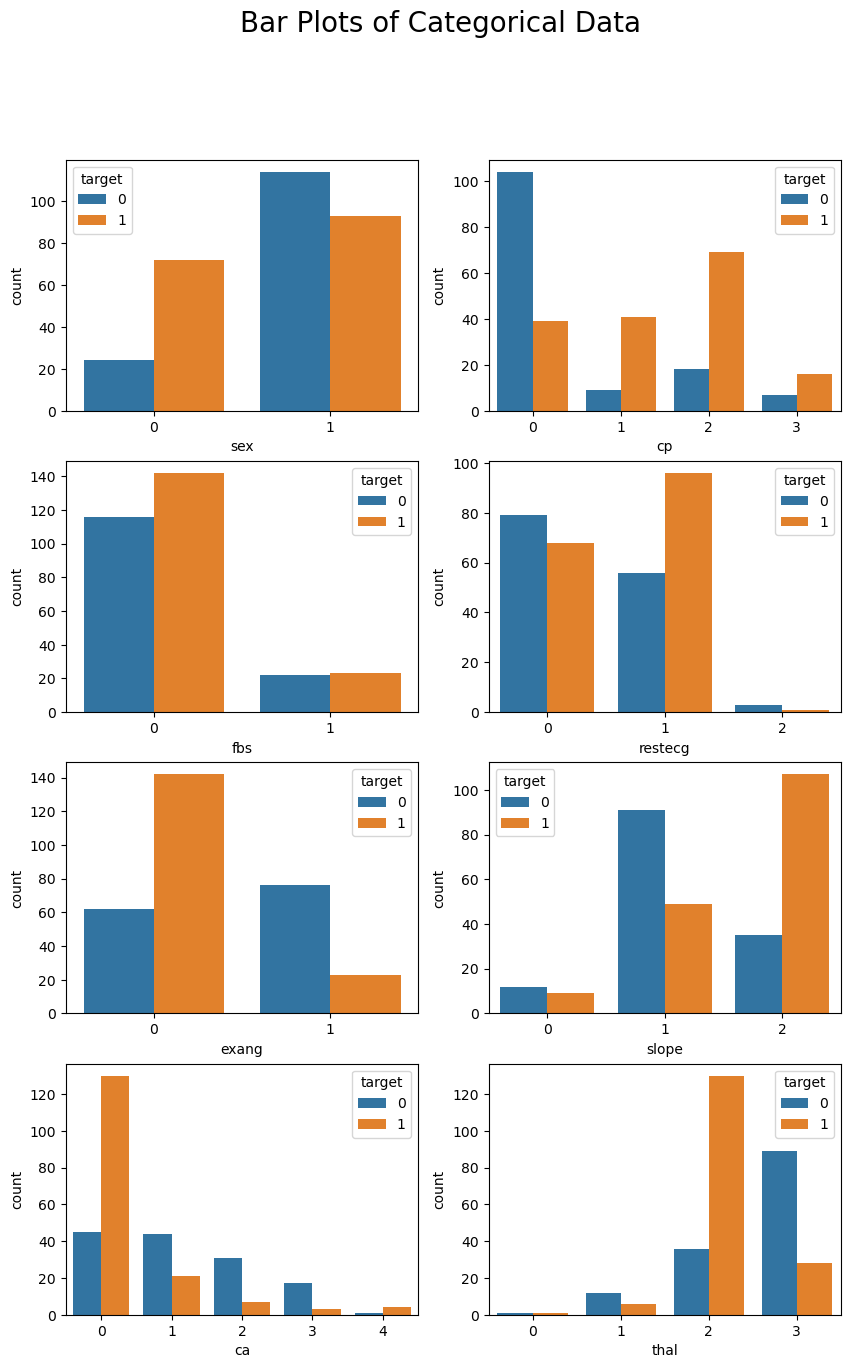

In [6]:
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

fig, ax = plt.subplots(4, 2, figsize=(10, 15))
fig.suptitle('Bar Plots of Categorical Data', fontsize=20)

def plot_cats(df, cols, target, ax):
    pos = 0
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            sns.countplot(x=cols[pos], hue=target, data=df, ax=ax[i, j])
            pos += 1
            
    plt.show()      
        
plot_cats(data, cat_cols, 'target', ax)

This may not look like much as all the categorical labels in the data have already been converted to numeric. But from this we can see that ca, cp and thal separate the target very well within that category.

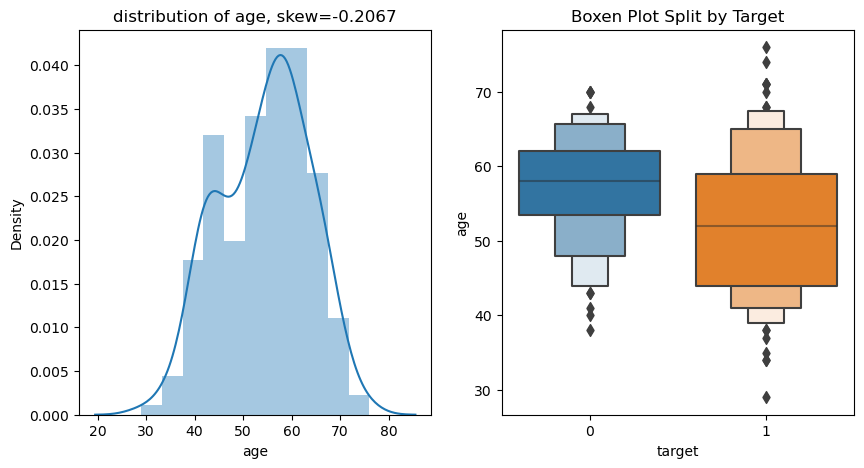

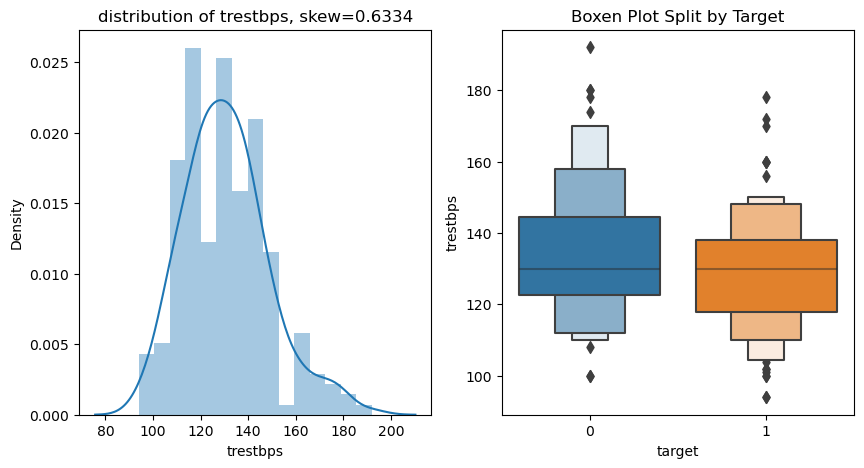

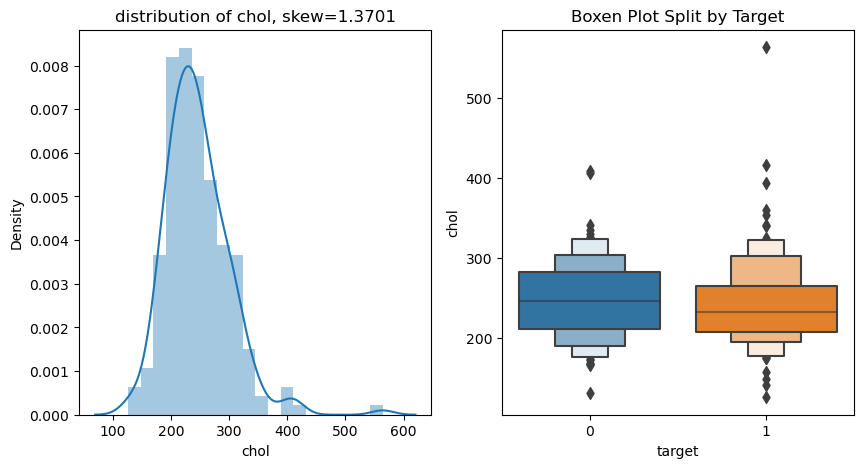

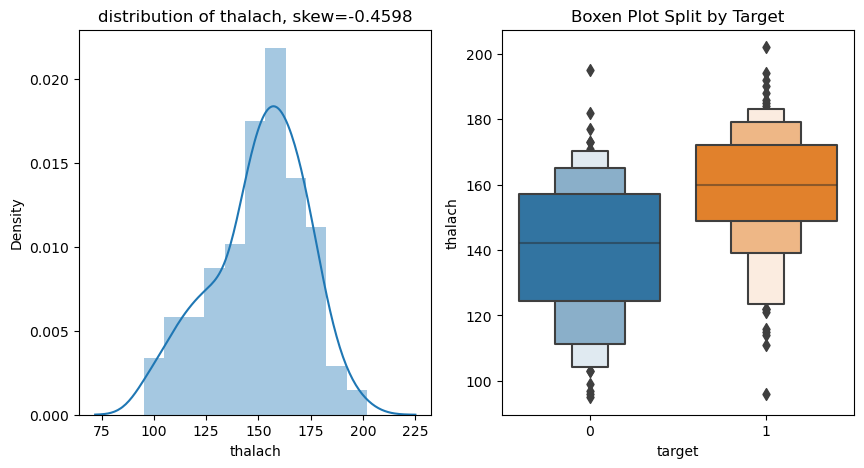

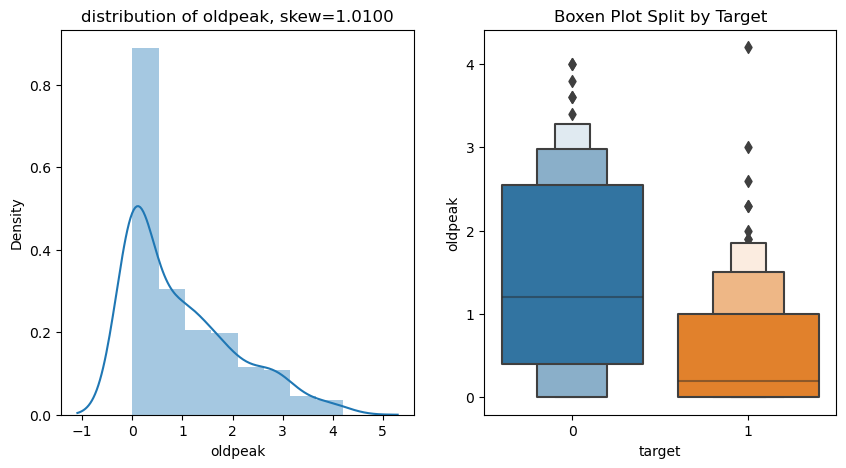

In [7]:
def plot_numeric(df, cols, target):
    for col in cols:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        sns.distplot(a=df[col], ax=ax[0])
        ax[0].set_title('distribution of {}, skew={:.4f}'.format(col, df[col].skew()))
        sns.boxenplot(data=df, x=target, y=col, ax=ax[1])
        ax[1].set_title('Boxen Plot Split by Target')
    plt.show()
        
plot_numeric(train_df, num_cols, 'target')

Above we can see that thalach and oldpeak have different distributions when split by the target this separation shows that they will be important features for classification.<br>
Next, we will scale the numeric columns using the StandardScaler from sklearn. This scales the data to have a mean of 0 and a standard deviation of 1.
Normally we would explore the data to find the best scaler for the particular problem however here we are just comparing the estimators.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [9]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
248,-0.042427,1,1,3.441776,0.679763,0,0,1.986171,0,-0.909003,2,1,3
281,-0.259162,1,0,-0.158688,-0.761152,1,1,0.249532,1,0.031498,1,0,0
162,-1.451205,1,1,-0.608746,-1.618405,0,1,1.407292,0,-0.909003,2,0,2
193,0.607778,1,0,0.797685,0.661523,0,0,-0.373877,1,1.724399,1,2,3
226,0.824513,1,1,-0.608746,0.643284,0,0,-2.110517,0,0.407698,1,1,3


## Feature Importance
Here we will use a random forest model to look at the importance of each feature to see if we can eliminate some as just noise.

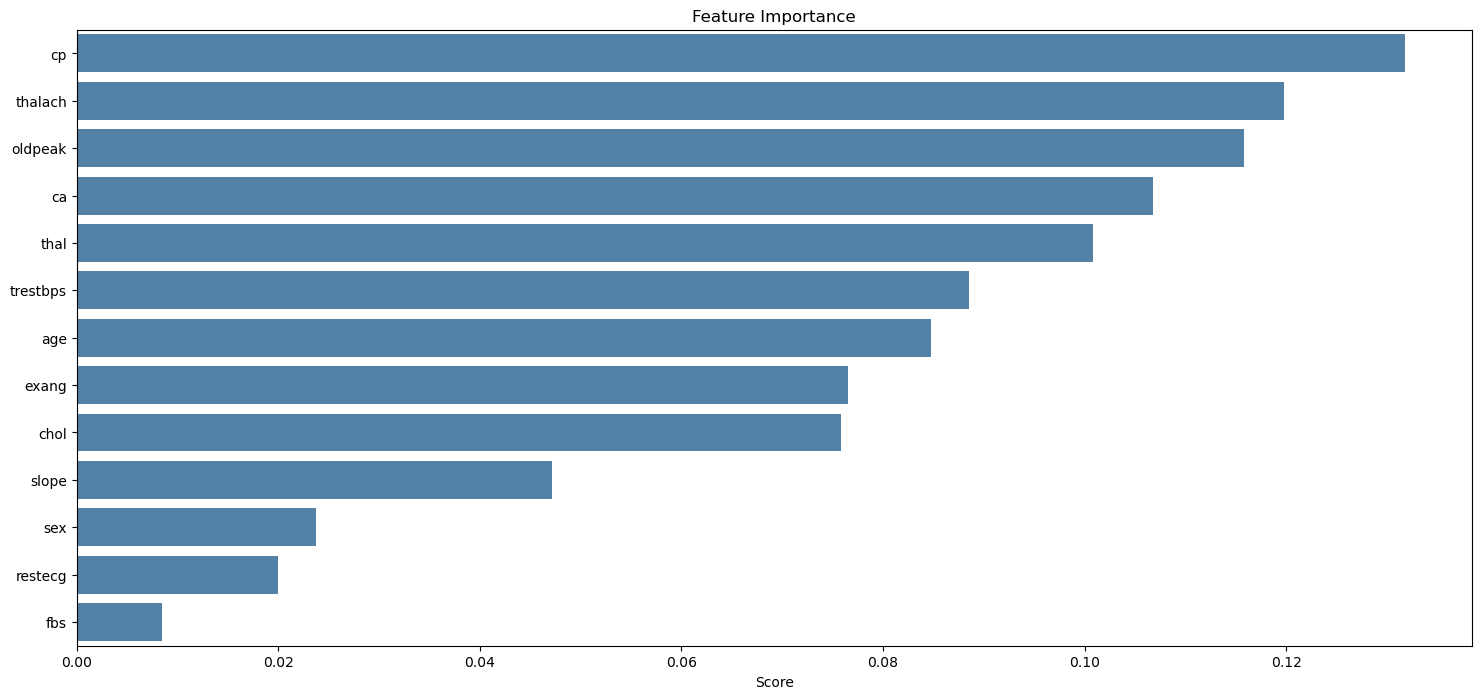

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

fig = plt.figure(figsize=(18, 8))
importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=importance, y=importance.index, color='steelblue')
plt.title('Feature Importance')
plt.xlabel('Score')
plt.show()

Looking at the feature importance our suspicions are confirmed that ca, cp, thal, thalach and oldpeak are very important to the models for this classification task.
We will then convert the categorical data. We are assuming here that the categories within each feature are independent of the others in that same feature. i.e. there is no hierarchy within each categorical feature itself. Again, that is not the purpose of this notebook.

In [11]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
X_train = np.concatenate((X_train[num_cols].values, ohe.fit_transform(X_train[cat_cols])), axis=1)
X_test = np.concatenate((X_test[num_cols].values, ohe.transform(X_test[cat_cols])), axis=1)
X_train.shape

(212, 30)

# Modeling
## Base untuned algorithms
We will use five different versions of the Adaboost Algorithm.<br>
1. Using the default Adaboost base estimator. It uses a decision stump with a max depth of 1.<br>
2. Using a decision tree classifier model as the base.<br>
3. Using an extra tree classifier model as the base.<br>
4. Using a logistic regression model as the base.<br>
5. Using a support vector machine classifier model as the base.

In [12]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


ada_base = AdaBoostClassifier()
ada_deci = AdaBoostClassifier(DecisionTreeClassifier())
ada_extr = AdaBoostClassifier(ExtraTreeClassifier())
ada_logr = AdaBoostClassifier(LogisticRegression())
ada_svml = AdaBoostClassifier(SVC(probability=True , kernel='linear'))

We will create a function to score the model using cross_val_score from sklearn.

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
def cv_score_model(mod, X, y, folds, scoring):
    cv = StratifiedKFold(n_splits=folds, shuffle=True)
    cv_estimate = cross_val_score(mod, X, y, cv=cv, scoring=scoring, n_jobs=4)
    return np.mean(cv_estimate), np.std(cv_estimate)

Here we will take the models and using the function above create a new function to fill a data frame with the scoring results. This will be done using each of the four different scoring parameters.

In [14]:
models = [ada_base, ada_deci, ada_extr, ada_logr, ada_svml]
model_names = ['Base', 'DecisonTree', 'ExtraTree', 'LogisticRegression', 'SVC']

def fill_results_df(mod_list, name_list, scoring_list, X, y, folds):
    
    results = pd.DataFrame(index=name_list)
    for score in scoring_list:
        sc_mean = '{}_mean'.format(score)
        sc_std = '{}_std'.format(score)
        for name, model in zip(name_list, mod_list):
            mean, std = cv_score_model(model, X, y, folds, score)
            results.loc[name, sc_mean] = mean
            results.loc[name, sc_std] = std
    
    return results
s = ['roc_auc', 'accuracy', 'precision', 'recall']
r = fill_results_df(models, model_names, s, X_train, y_train, 10)
print('Results from untuned classifiers')
r

Results from untuned classifiers


,roc_auc_mean,roc_auc_std,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std
Base,0.845499,0.075891,0.811039,0.037839,0.793716,0.093268,0.835897,0.101566
DecisonTree,0.751004,0.062410,0.765801,0.094694,0.794235,0.080487,0.783974,0.093732
ExtraTree,0.814722,0.087092,0.740693,0.106983,0.779542,0.063191,0.793590,0.112784
LogisticRegression,0.903241,0.066976,0.815801,0.086701,0.855028,0.100133,0.851923,0.126639
SVC,0.895726,0.044584,0.702165,0.099620,0.647542,0.050050,1.000000,0.000000


As we can see above the best performing model out of the box has a logistic regression base.
## Tuning

Next, we turn to tuning the models to see if we can do better. This will be done using grid search.

In [15]:
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV

For each of the models we will create a parameter grid to search over and these will all be using the roc_auc as the scoring parameter to tune.

In [16]:
base = clone(ada_base)
base.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [17]:
cv=StratifiedKFold(n_splits=10, shuffle=True)

param_grid={'n_estimators' :[100, 250, 500, 750],
            'learning_rate' :[0.001, 0.01, 0.1]}


base_grid = GridSearchCV(estimator=base,
                        param_grid=param_grid,
                        cv=cv,
                        scoring='roc_auc',
                        return_train_score=True,
                        n_jobs=4,
                        verbose=1)

base_grid.fit(X_train, y_train)
base_best_mod = base_grid.best_estimator_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [18]:
print('For Adaboost with default decision stump as base estimator\n')
print('Best GridSearchCV Score roc_auc {}'.format(base_grid.best_score_))
print('Hyperparameters                 Values')
print('n_estimators:                    {}'.format(base_grid.best_estimator_.n_estimators))
print('learning_rate:                   {}'.format(base_grid.best_estimator_.learning_rate))

For Adaboost with default decision stump as base estimator

Best GridSearchCV Score roc_auc 0.9057122507122506
Hyperparameters                 Values
n_estimators:                    750
learning_rate:                   0.01


In [19]:
deci = clone(ada_deci)
deci.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [20]:
cv=StratifiedKFold(n_splits=10, shuffle=True)

param_grid = {'estimator__criterion' :['gini', 'entropy'],
              'estimator__max_depth' :[1, 2],
              'estimator__min_samples_split' :[2, 3],
              'estimator__min_samples_leaf' :[3, 5 ,10],
              'n_estimators' :[100, 250, 500, 750, 1000],
              'learning_rate' :[0.001, 0.01, 0.1]}


deci_grid = GridSearchCV(estimator=deci,
                        param_grid=param_grid,
                        cv=cv,
                        scoring='roc_auc',
                        return_train_score=True,
                        n_jobs=4,
                        verbose=1)

deci_grid.fit(X_train, y_train)
deci_best_mod = deci_grid.best_estimator_

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


In [21]:
print('For Adaboost with decision tree as base estimator\n')
print('Best GridSearchCV roc_auc Score {}'.format(deci_grid.best_score_))
print('Hyperparameters                   Values')
print('estimator__criterion:               {}'.format(deci_grid.best_estimator_.estimator.criterion))
print('estimator__max_depth:               {}'.format(deci_grid.best_estimator_.estimator.max_depth))
print('estimator__min_samples_split:       {}'.format(deci_grid.best_estimator_.estimator.min_samples_split))
print('estimator__min_samples_leaf:        {}'.format(deci_grid.best_estimator_.estimator.min_samples_leaf))
print('n_estimators:                       {}'.format(deci_grid.best_estimator_.n_estimators))
print('learning_rate:                      {}'.format(deci_grid.best_estimator_.learning_rate))

For Adaboost with decision tree as base estimator

Best GridSearchCV roc_auc Score 0.8935185185185185
Hyperparameters                   Values
estimator__criterion:               gini
estimator__max_depth:               1
estimator__min_samples_split:       2
estimator__min_samples_leaf:        5
n_estimators:                       1000
learning_rate:                      0.01


In [22]:
extr = clone(ada_extr)
extr.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'random',
 'estimator': ExtraTreeClassifier(),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [23]:
cv=StratifiedKFold(n_splits=10, shuffle=True)

param_grid = {'estimator__criterion' :['gini', 'entropy'],
              'estimator__max_depth' :[2, 5],
              'estimator__min_samples_split' :[2, 3],
              'estimator__min_samples_leaf' :[3, 5 ,10],
              'n_estimators' :[100, 250, 500, 750],
              'learning_rate' :[0.001, 0.01, 0.1]}



extr_grid = GridSearchCV(estimator=extr,
                        param_grid=param_grid,
                        cv=cv,
                        scoring='roc_auc',
                        return_train_score=True,
                        n_jobs=4,
                        verbose=1)

extr_grid.fit(X_train, y_train)
extr_best_mod = extr_grid.best_estimator_

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


In [24]:
print('For Adaboost with extra tree as base estimator\n')
print('Best GridSearchCV roc_auc Score {}'.format(extr_grid.best_score_))
print('Hyperparameters                   Values')
print('estimator__criterion:               {}'.format(extr_grid.best_estimator_.estimator.criterion))
print('estimator__max_depth:               {}'.format(extr_grid.best_estimator_.estimator.max_depth))
print('estimator__min_samples_split:       {}'.format(extr_grid.best_estimator_.estimator.min_samples_split))
print('estimator__min_samples_leaf:        {}'.format(extr_grid.best_estimator_.estimator.min_samples_leaf))
print('n_estimators:                       {}'.format(extr_grid.best_estimator_.n_estimators))
print('learning_rate:                      {}'.format(extr_grid.best_estimator_.learning_rate))

For Adaboost with extra tree as base estimator

Best GridSearchCV roc_auc Score 0.9067165242165244
Hyperparameters                   Values
estimator__criterion:               gini
estimator__max_depth:               5
estimator__min_samples_split:       2
estimator__min_samples_leaf:        3
n_estimators:                       100
learning_rate:                      0.01


In [25]:
logr = clone(ada_logr)
logr.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [26]:
cv=StratifiedKFold(n_splits=10, shuffle=True)

param_grid = {'estimator__C' :[0.1, 1, 10, 50, 100],
              'n_estimators' :[100, 250, 500, 750],
              'learning_rate' :[0.0001, 0.001, 0.01, 0.1]}



logr_grid = GridSearchCV(estimator=logr,
                        param_grid=param_grid,
                        cv=cv,
                        scoring='roc_auc',
                        return_train_score=True,
                        n_jobs=4,
                        verbose=1)

logr_grid.fit(X_train, y_train)
logr_best_mod = logr_grid.best_estimator_

Fitting 10 folds for each of 80 candidates, totalling 800 fits


In [27]:
print('For Adaboost with logistic regression as base estimator\n')
print('Best GridSearchCV roc_auc Score {}'.format(logr_grid.best_score_))
print('Hyperparameters           Values')
print('estimator__C:               {}'.format(logr_grid.best_estimator_.estimator.C))
print('n_estimators:               {}'.format(logr_grid.best_estimator_.n_estimators))
print('learning_rate:              {}'.format(logr_grid.best_estimator_.learning_rate))

For Adaboost with logistic regression as base estimator

Best GridSearchCV roc_auc Score 0.923511396011396
Hyperparameters           Values
estimator__C:               100
n_estimators:               500
learning_rate:              0.001


In [28]:
svml = clone(ada_svml)
svml.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'linear',
 'estimator__max_iter': -1,
 'estimator__probability': True,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(kernel='linear', probability=True),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [29]:
cv=StratifiedKFold(n_splits=10, shuffle=True)

param_grid = {'estimator__C' :[0.01, 0.1, 1, 10],
              'n_estimators' :[100, 250, 500, 750],
              'learning_rate' :[0.001, 0.01, 0.1]}



svml_grid = GridSearchCV(estimator=svml,
                        param_grid=param_grid,
                        cv=cv,
                        scoring='roc_auc',
                        return_train_score=True,
                        n_jobs=4,
                        verbose=1)

svml_grid.fit(X_train, y_train)
svml_best_mod = svml_grid.best_estimator_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [30]:
print('For Adaboost with linear kernal SVM as base estimator\n')
print('Best GridSearchCV roc_auc Score {}'.format(svml_grid.best_score_))
print('Hyperparameters           Values')
print('estimator__C:               {}'.format(svml_grid.best_estimator_.estimator.C))
print('n_estimators:               {}'.format(svml_grid.best_estimator_.n_estimators))
print('learning_rate:              {}'.format(svml_grid.best_estimator_.learning_rate))

For Adaboost with linear kernal SVM as base estimator

Best GridSearchCV roc_auc Score 0.9160185185185185
Hyperparameters           Values
estimator__C:               0.01
n_estimators:               100
learning_rate:              0.01


In [31]:
s = ['roc_auc', 'accuracy', 'precision', 'recall']
mod_names = ['Base', 'DecisonTree', 'ExtraTree', 'LogisticRegression', 'SVC']
mods = [clone(base_best_mod), clone(deci_best_mod), clone(extr_best_mod), clone(logr_best_mod), clone(svml_best_mod)]

final_results = fill_results_df(mods, mod_names, s, X_train, y_train, 10)
print('Results from tuned classifiers')
final_results

Results from tuned classifiers


,roc_auc_mean,roc_auc_std,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std
Base,0.905798,0.055744,0.839177,0.044633,0.873998,0.059970,0.850641,0.128367
DecisonTree,0.891282,0.056122,0.839177,0.049454,0.854629,0.074497,0.883974,0.076680
ExtraTree,0.909544,0.063966,0.830519,0.084765,0.847526,0.034244,0.842308,0.114999
LogisticRegression,0.896396,0.053085,0.844589,0.092172,0.871054,0.079209,0.885256,0.082114
SVC,0.901759,0.057949,0.848485,0.067127,0.877132,0.094358,0.851923,0.059477


From these results we can see that the extra tree and logistic regression did the best. Although there was not a big improvement in the logistic regression model.
## Testing

Finally, lets see how they do on the test data. Lets create a grade model function that scores the model based on the probabilities predicted given a threshold. This threshold can be adjusted based on what's important. i.e., do we want to increase true positives or decrease false positives etc.

In [32]:
def grade_model(probs, thresh):
    return np.array([1 if x>=thresh else 0 for x in probs[:,1]])

Here we fit all the individual models and get the predicted probabilities. Then we score them based on a threshold of 0.5.

In [33]:
best_probs = []
for mod in mods:
    temp_mod = clone(mod)
    temp_mod.fit(X_train, y_train)
    best_probs.append(temp_mod.predict_proba(X_test))
    
best_scores = []
for pb in best_probs:
    best_scores.append(grade_model(pb, .5))

We will then take the scores and plot the roc curve to compare the predicted and actual labels. We will also show the confusion matrix and plot that as well.

In [34]:
from sklearn.metrics import confusion_matrix, auc, roc_curve

def plot_auc(labels, probs, ax, mod_name):
    fpr, tpr, threshold = roc_curve(labels, probs[:,1])
    roc = auc(fpr, tpr)
    sns.lineplot(x=fpr, y=tpr, ax=ax, ci=None, label='AUC = {:.4f}'.format(roc))
    sns.lineplot(x=[0, 1], y=[0, 1], ax=ax)
    ax.legend(loc = 'lower right')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title('Receiver Operating Characteristic for {}'.format(mod_name))
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    return plt

In [35]:
from pandas.plotting import table

def plot_confusion(lab, scor, mod_name, ax):
    conf = confusion_matrix(lab, scor)
    tab = pd.DataFrame(conf, columns=['Score positive', 'Score negative'], index=['Actual positive', 'Actual negative'])
    t = table(ax , tab, loc='center')
    t.scale(1, 3)
    ax.set_title('Confusion matrix for {}'.format(mod_name))
    ax.axis('off')

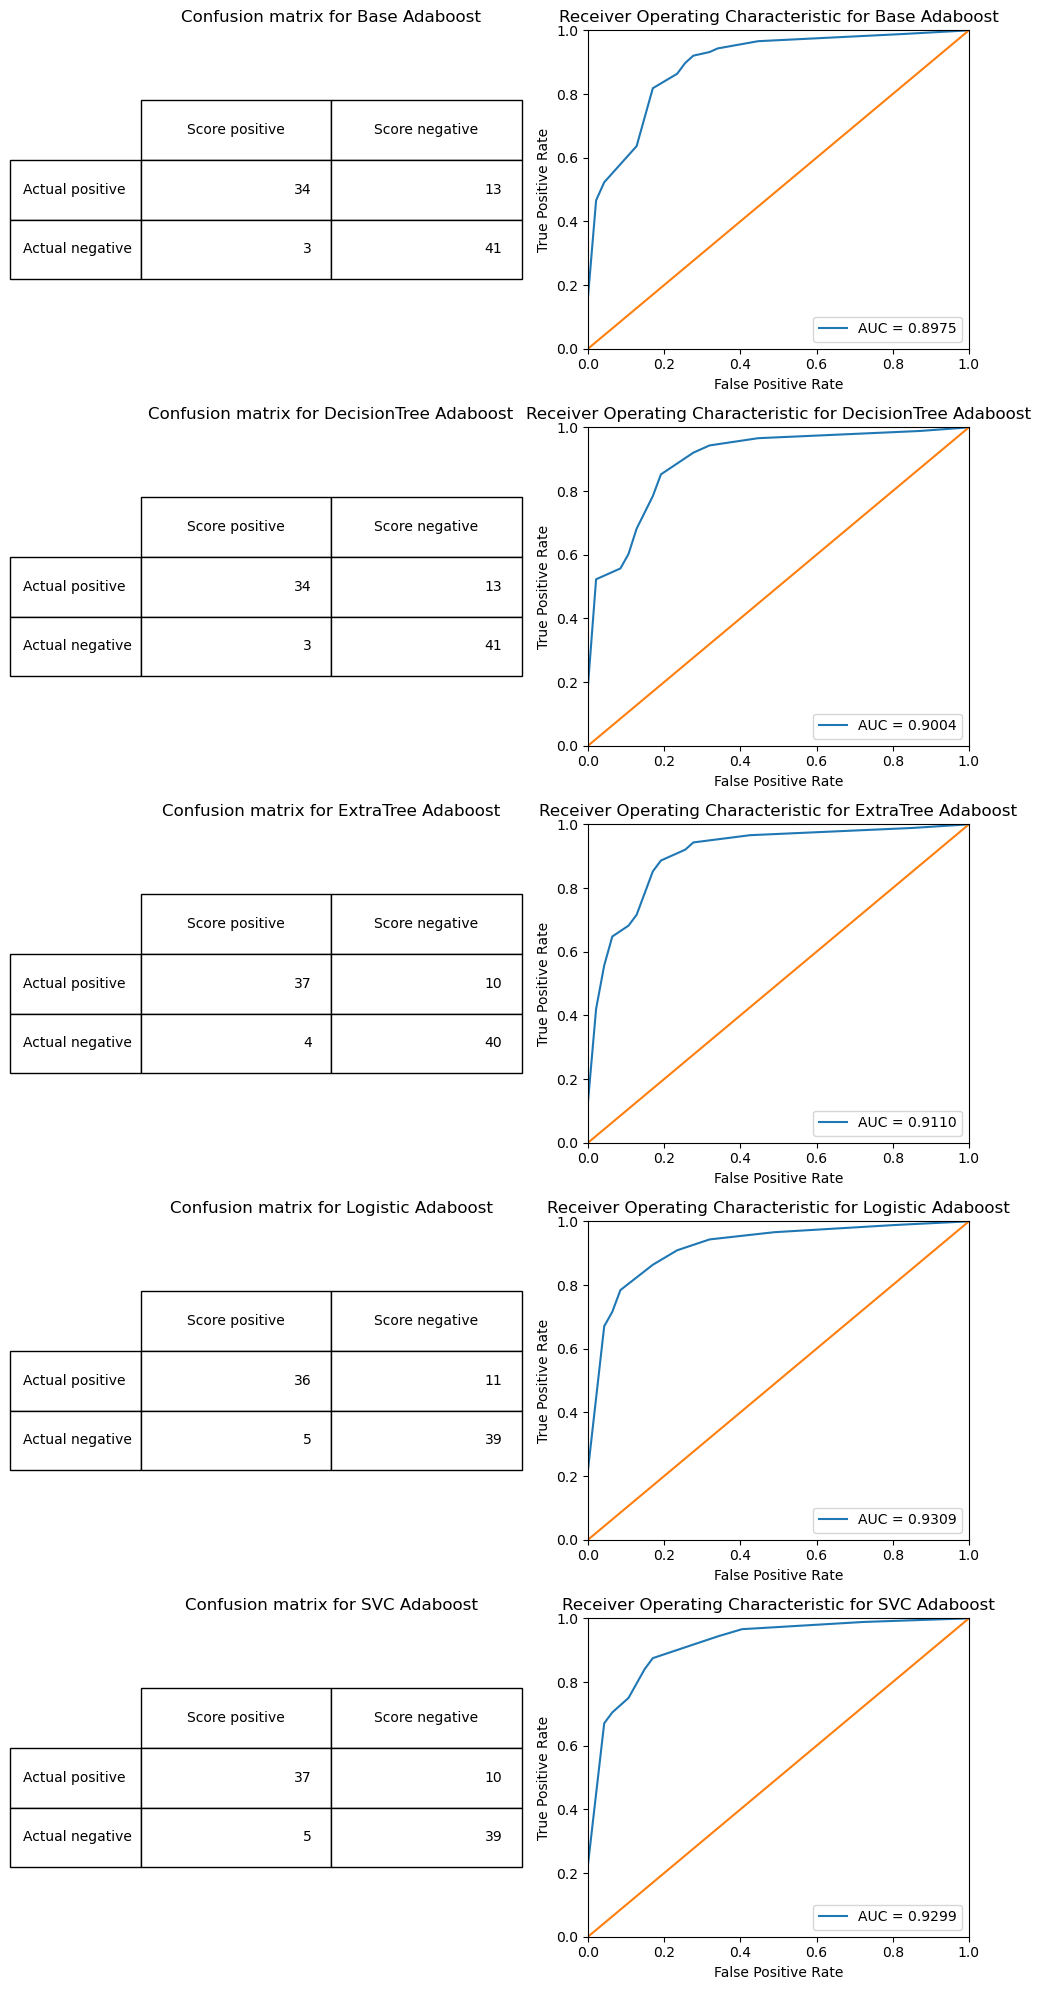

In [36]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

plot_confusion(y_test, best_scores[0], 'Base Adaboost', ax[0, 0])
plot_auc(y_test, best_probs[0], ax[0, 1], 'Base Adaboost')

plot_confusion(y_test, best_scores[1], 'DecisionTree Adaboost', ax[1, 0])
plot_auc(y_test, best_probs[1], ax[1, 1], 'DecisionTree Adaboost')

plot_confusion(y_test, best_scores[2], 'ExtraTree Adaboost', ax[2, 0])
plot_auc(y_test, best_probs[2], ax[2, 1], 'ExtraTree Adaboost')

plot_confusion(y_test, best_scores[3], 'Logistic Adaboost', ax[3, 0])
plot_auc(y_test, best_probs[3], ax[3, 1], 'Logistic Adaboost')

plot_confusion(y_test, best_scores[4], 'SVC Adaboost', ax[4, 0])
plot_auc(y_test, best_probs[4], ax[4, 1], 'SVC Adaboost')

plt.tight_layout()

# Conclusion
As was shown here simple learners especially linear learners like logistic regression and the support vector machine classifier with a linear kernel outperformed the decision tree based classifiers. This may be due to the overall relationship within the data. But in this case the linear models take the day. I am impressed by how well the logistic regression model did without tuning.

## Sources
Ashish Kumar, Great Learning. “AdaBoost Algorithm: Boosting Algorithm in Machine Learning.”<br>GreatLearning Blog: Free Resources What Matters to Shape Your Career!,<br> 28 May 2020, www.mygreatlearning.com/blog/adaboost-algorithm/.<br> Accessed 15 June 2021

## Documentation

In [37]:
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,seaborn,sklearn

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.8.0

numpy     : 1.23.5
pandas    : 1.5.2
matplotlib: 3.6.2
seaborn   : 0.12.2
sklearn   : 1.2.0

